# Assignment 5
## Decision Trees and Random Forests for Regression

### About this notebook

The notebook has two parts, as has the assignment, the first part being a "tutorial like" walkthrough, the second asking you to implement a regression tree yourself. Hence, when going through the first part, remember that you need to have time left to actually work with the second!

Both parts of the assignment can be handled within this notebook, however, the ID3-implementation should be done in a separate Python-script (ID3_reg.py). Feel free to move the second part to its own notebook for better overview. In any case, if you make changes in the Python file, you might need to restart the kernel for the notebook that is using it, so that changes get properly loaded.


In [ ]:
# YOU DON'T HAVE TO RUN THIS IF EVERYTHING IS ALREADY INSTALLED CORRECTLY
!pip3 install --upgrade pip
!pip3 install graphviz
!pip3 install dtreeviz
!pip3 install numpy scipy

In [1]:
import numpy as np
from collections import Counter
from ordered_set import OrderedSet
from graphviz import Digraph
from sklearn import tree, metrics, datasets
from ordered_set import OrderedSet


class ID3RegressionTreePredictor :


    def __init__(self, minSamplesLeaf = 1, minSamplesSplit = 2, maxDepth = 100, stopMSE = 0.0) :

        self.__nodeCounter = -1
        
        self.__dot = Digraph()

        self.__minSamplesLeaf = minSamplesLeaf
        self.__minSamplesSplit = minSamplesSplit
        self.__maxDepth = maxDepth
        self.__stopMSE = stopMSE

        self.__numOfAttributes = 0
        self.__attributes = None
        self.__target = None
        self.__data = None

        self.__tree = None

    def newID3Node(self):
        self.__nodeCounter += 1
        return {'id': self.__nodeCounter, 'splitValue': None, 'nextSplitAttribute': None, 'mse': None, 'samples': None,
                         'avgValue': None, 'nodes': None}


    def addNodeToGraph(self, node, parentid):
        nodeString = ''
        for k in node:
            if ((node[k] != None) and (k != 'nodes')):
                nodeString += "\n" + str(k) + ": " + str(node[k])

        self.__dot.node(str(node['id']), label=nodeString)
        if (parentid != None):
            self.__dot.edge(str(parentid), str(node['id']))
            nodeString += "\n" + str(parentid) + " -> " + str(node['id'])


        return

    
    def makeDotData(self) :
        return self.__dot


    # stubb that can be extended to a full blown MSE calculation.
    def calcMSE(self, dataIDXs) :
        if len(dataIDXs)==0:
            return 0, 0

        

        _targets = self.__target[list(dataIDXs)]
        avg = np.mean(_targets)
        # mse=0
        # for i in dataIDXs:
        #     mse += (self.__target[i] - avg)**2

        #print("körs")
        
        mse = sum( (_targets-avg)**2  )
        
        # print("MSE: ", mse, "AVG", avg , "Targets shape : " , _targets.shape)
        return mse, avg

    
    # find the best split attribute out of the still possible ones ('attributes')
    # over a subset of self.__data specified through a list of indices (dataIDXs)
    def findSplitAttr(self, attributes, dataIDXs) :

        minMSE = float("inf")
        
        splitAttr = ''
        splitMSEs = {}
        splitDataIDXs = {}
        splitAverages = {}
        
        t_splitMSEs = {}
        t_splitDataIDXs = {}
        t_splitAverages = {}
        
        #MSE = self.calcMSE(dataIDXs)
        attr_list = list(self.__attributes.keys())
        
       # print("dataIDXs : " , dataIDXs)
        
        
        #print("Attributes type: ",type(attributes), "Attributes :", attributes)
        for attr in attributes:
            oMSE = 0
            i = attr_list.index(attr)
            
            for val in self.__attributes[attr]:

                
                #idxs = np.where(self.__data[list(dataIDXs),i] == val)[0]
                idxs = [idx for idx in dataIDXs if self.__data[idx][i] == val]

                # print("indices : " , idxs)
                
                my_mse, my_avg = self.calcMSE(idxs)
                oMSE += my_mse
                t_splitMSEs[val] = my_mse
                t_splitDataIDXs[val] = idxs
                t_splitAverages[val] = my_avg
            if oMSE < minMSE:
                splitMSEs = t_splitMSEs
                splitDataIDXs = t_splitDataIDXs
                splitAverages = t_splitAverages
                
                minMSE = oMSE
                splitAttr = attr
            
            t_splitMSEs = {}
            t_splitDataIDXs = {}
            t_splitAverages = {}
            
            
            
            
        

        # ****************************************************************************************
        # Provide your code here (and in potentially needed help methods, like self.calcMSE
        #
        # You find the data in self.__data and target values in self.__target
        # The data set for which you should find the best split attribute by 
        # calculating the overall MSE for the respective subsets is specified 
        # through the parameter 'dataIDXs', i.e. self.__data and self.__target
        # will never need to be altered themselves, and no copies are needed 
        # either!
        #
        # Return:
        # - minMSE: the minimal MSE resulting from your calculations
        # - splitAttr: the attribute that, if used as split attribute, gives the minMSE
        # - splitMSEs: a dictionary (keys: attribute values, values: MSEs) with the MSEs 
        #              in each subset resulting from the split
        # - splitAveragesFinal: a dictionary (keys: attribute values, values: average values) 
        #                       with the average value (prediction) of each subset
        # - splitDataIDXsFinal: a dictionary (keys: attribute values, values: subset data indices)
        #                       with the list of indices for each subset
        #*****************************************************************************************
        
        
        
        
        return minMSE, splitAttr, splitMSEs, splitAverages, splitDataIDXs


    # the starting point for fitting the tree
    # you should not need to change anything in here
    def fit(self, data, target, attributes):

        self.__numOfAttributes = len(attributes)
        self.__attributes = attributes
        self.__data = data
        self.__target = target

        
        dataIDXs = {j for j in range(len(data))}

        mse, avg = self.calcMSE(dataIDXs)
        
        attributesToTest = list(self.__attributes.keys())
        
        self.__tree = self.fit_rek( 0, None, '-', attributesToTest, mse, avg, dataIDXs)

        return self.__tree


    # the recursive tree fitting method
    # you should not need to change anything in here
    def fit_rek(self, depth, parentID, splitVal, attributesToTest, mse, avg, dataIDXs) :

        root = self.newID3Node()
        
        root.update({'splitValue':splitVal, 'mse': mse, 'samples': len(dataIDXs)})
        currentDepth = depth
               
        if (currentDepth == self.__maxDepth or mse <= self.__stopMSE or len(attributesToTest) == 0 or len(dataIDXs) < self.__minSamplesSplit):
            root.update({'avgValue':avg})
            self.addNodeToGraph(root, parentID)
            return root

        minMSE, splitAttr, splitMSEs, splitAverages, splitDataIDXs = self.findSplitAttr(attributesToTest, dataIDXs)


        root.update({'nextSplitAttribute': splitAttr, 'nodes': {}})
        self.addNodeToGraph(root, parentID)

        attributesToTestCopy = OrderedSet(attributesToTest)
        attributesToTestCopy.discard(splitAttr)

        #print(splitAttr, splitDataIDXs)

        for val in self.__attributes[splitAttr] :
            #print("testing " + str(splitAttr) + " = " + str(val))
            if( len(splitDataIDXs[val]) < self.__minSamplesLeaf) :
                root['nodes'][val] = self.newID3Node()
                root['nodes'][val].update({'splitValue':val, 'samples': len(splitDataIDXs[val]), 'avgValue': splitAverages[val]})
                self.addNodeToGraph(root['nodes'][val], root['id'])
                #print("leaf, not enough samples, setting node-value = " + str(splitAverages[val]))
                
            else :
                root['nodes'][val] = self.fit_rek( currentDepth+1, root['id'], val, attributesToTestCopy, splitMSEs[val], splitAverages[val], splitDataIDXs[val])

        return root

    # Doing a prediction for a data set 'data' (starting method for the recursive tree traversal)
    def predict(self, data) :
        predicted = list()

        for i in range(len(data)) :
            predicted.append(self.predict_rek(data[i], self.__tree))

        return predicted

    # Recursively traverse the tree to find the value for the sample 'sample'
    def predict_rek(self, sample, node) :

        if(node['avgValue'] != None) :
            return node['avgValue']

        attr = node['nextSplitAttribute']
        dataIDX = list(self.__attributes.keys()).index(attr)
        val = sample[dataIDX]
        next = node['nodes'][val]

        return self.predict_rek( sample, next)
    
    def score(self, data, target) :
        score = 1.0
        y_true = target
        y_pred = self.predict(data)
        u = sum((y_true - y_pred)** 2)
        v = sum((y_true - np.mean(y_true)) ** 2)
        score = 1 - u/v
        
        
        # ************************************************
        # Implement your score method here
        # ************************************************
        
        return score



# Part 1

## Dataset

First we load the dataset. Ultimately, you should be working with the California housing data, but for quicker test runs, it might help to first start out with the Diabetes data.

In [2]:
#run time 0.8s

from sklearn.datasets import load_diabetes
from sklearn.datasets import fetch_california_housing
from ConceptDataRegr import ConceptDataRegr
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#test_case = 'diabetes'
test_case = 'california'

if test_case == 'california':
    dataset = fetch_california_housing()
elif test_case == 'diabetes':
    dataset = load_diabetes()
else:
    raise ValueError('Unknown test case')

X = dataset.data
y = dataset.target

#run time 0.7s

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15
X = dataset.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)


In [8]:
X.shape


(20640, 8)

Some information about the dataset you're looking at

In [9]:
if test_case == 'california' :
    print("target:", list(dataset.target_names))
print("features:", list(dataset.feature_names))
print("description:", dataset.DESCR)


target: ['MedHouseVal']
features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
description: .. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was deri

Split it into train, validation and test sets.

In [10]:
#run time 0.7s

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15
X = dataset.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)

In [ ]:
X_train.shape


What is the reason why you would like to have validation and test set and not just a test set?

More guiding questions:
How can you use the validation set?
Can you use the validation set in some way to tune the hyperparameters of your model?
Can you use the test set to tune the hyperparameters of your model?
You can come back to these questions later if you're not sure yet.

## Decision Tree Regressor

Run the cells below and inspect the output. Use the documentation where needed. Be prepared to answer questions posed by the TA.

In [12]:
#run time 0.7s

regressor1 = DecisionTreeRegressor(random_state=0)

Now let's examine the decision tree.

In [13]:
#run time 1.8s

from sklearn.model_selection import cross_val_score

cross_val_score(regressor1, X_train, y_train, cv=10)

array([0.57348072, 0.62233863, 0.6045285 , 0.5893524 , 0.5833089 ,
       0.59548208, 0.57223303, 0.54706611, 0.53318603, 0.66383834])

In [14]:
#run time 0.3s

regressor1.fit(X_train, y_train)
regressor1.score(X_test, y_test)

0.5930714269134938

What do these numbers mean?
Check out [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
and [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision+tree)
to find the answers.

How do you interpret the numbers?

Let's have a look at two other parameters, max_depth and min_samples_leaf.
How do you interpret the following numbers?

## Decision Tree Parameters

In [21]:
#run time 0.2s

regressor2 = DecisionTreeRegressor(max_depth=1, random_state=0)
cross_val_score(regressor2, X_train, y_train, cv=10)

array([0.3093173 , 0.31084997, 0.3238698 , 0.26062284, 0.34982138,
       0.28834936, 0.31131296, 0.32220031, 0.26295319, 0.36589174])

In [22]:
#run time 0.1s

regressor2.fit(X_train, y_train)
regressor2.score(X_test, y_test)

0.2958635051924463

In [23]:
#run time 1.2s

regressor3 = DecisionTreeRegressor(min_samples_leaf=60, random_state=0)
cross_val_score(regressor3, X_train, y_train, cv=10)

array([0.69079973, 0.6957798 , 0.70731982, 0.66467126, 0.71251196,
       0.69738931, 0.68688216, 0.68174247, 0.64622999, 0.72972825])

In [24]:
#run time 0.1s

regressor3.fit(X_train, y_train)
regressor3.score(X_test, y_test)

0.6830318736673362

## Decision Tree Visualization

The next cells give examples how to visualize regressor2 and regressor3.

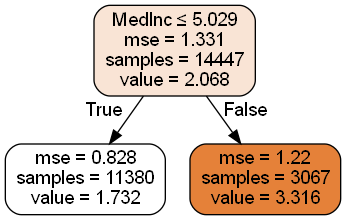

In [29]:
#run time 0.2s

from sklearn import tree
import graphviz
from IPython.display import Image

dot_data = tree.export_graphviz(regressor2, feature_names=dataset.feature_names, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_regressor2")
Image("decision_tree_regressor2.png")

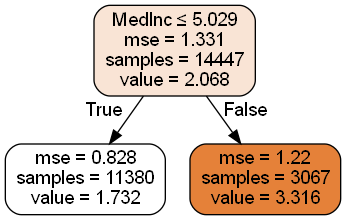

In [32]:
#run time 4.8s

dot_data = tree.export_graphviz(regressor2, feature_names=dataset.feature_names, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data, format="png") 
graph.render("wtf")
Image("wtf.png")

Another nice way to visualize the decision trees nicely is with dtreeviz. To make these plots it takes quite some time, so we recommend to use this visualization tool for trees with few nodes. 

In [ ]:
# run time 6.9s

from dtreeviz.trees import dtreeviz

viz = dtreeviz(regressor2, X, y,
                target_name="target",
                feature_names=dataset.feature_names)
#viz.view()
# this opens the visualization in a new window. If you want to display the output inside the notebook use:
viz
# if you want to store the output in a file use:
#viz.save("dtreeviz.svg")
# instead

## Explainability

If you want to visualize (explain) the decision path for one prediction, you can also use dtreeviz:

In [ ]:
# run time 6.8s

import numpy as np
inx=np.random.randint(0, len(X_test))

sample = X_test[inx,:] # random sample from training

viz = dtreeviz(regressor2, X, y,
                target_name="target",
                feature_names=dataset.feature_names,
                X=sample)
#viz.view()
viz




In [ ]:
y_test[inx]

For bigger graphs you just show the decision path

In [ ]:
#run time 10.4s

viz = dtreeviz(regressor3, X, y,
                target_name="target",
                feature_names=dataset.feature_names,
                X=sample,
                show_just_path=True)
#viz.view()
viz

Another option to explain the prediction for big trees is this

In [ ]:
# run time 0.1s

from dtreeviz.trees import explain_prediction_path

print(explain_prediction_path(regressor3, sample, feature_names=dataset.feature_names, explanation_type="plain_english"))



## Pruning

### Cost Complexity Pruning

A smart way of pruning is to use cost complexity pruning. This method is based on the idea that a tree with a lot of nodes is more likely to overfit than a tree with few nodes. Therefore, we can prune the tree by removing nodes that are not important for the prediction. The cost complexity pruning method uses a parameter $\alpha$ to determine how many nodes to remove. It basically is a tradeoff between having a tree with many nodes that has a small total MSE, vs. a tree with fewer nodes but greater total MSE. The following code shows how to use the cost complexity pruning method.

We find the alphas that change the Decision Tree to be "cut down" and we record the worsening of the MSE.

In [ ]:
# run time 0.8s

path = regressor1.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas[-1]

We can then plot the MSE for each $\alpha$.



## Is impurity gini- impurity or MSE ? 


In [ ]:
# run time 0.4s

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

You can now train a Decision Tree for each $\alpha$.

In [ ]:
# run time 0.2s

regressors = []
for ccp_alpha in ccp_alphas:
    regressor = DecisionTreeRegressor( random_state=0, ccp_alpha=ccp_alpha)
    regressor.fit(X_train, y_train)
    regressors.append(regressor)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        regressors[-1].tree_.node_count, ccp_alphas[-1]
    ),
)
if regressors[-1].tree_.node_count == 1:
    print("Removing last node.")
    regressors = regressors[:-1]
    ccp_alphas = ccp_alphas[:-1]

In [ ]:
# run time 0.5s

node_counts = [regressor.tree_.node_count for regressor in regressors]
depth = [regressor.tree_.max_depth for regressor in regressors]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

This is a way to get all the scores for each tree

In [ ]:
# run time 0.6s

train_scores = [regressor.score(X_train, y_train) for regressor in regressors]
val_scores = [regressor.score(X_val, y_val) for regressor in regressors]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

The best tree is the one with the highest score.

In [ ]:
# run time 0.8s

idx_max = np.argmax(val_scores)
regressor_best = regressors[idx_max]
print("Best alpha: {}".format(ccp_alphas[idx_max]))

In [ ]:
# run time 0.7s
regressor_best.score(X_test, y_test)

In [ ]:
# run time 0.8s

dot_data = tree.export_graphviz(regressor_best, feature_names=dataset.feature_names, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_regressor_best")
Image("decision_tree_regressor_best.png")

## Ensemble methods: 

Experiment with at least two methods. Inspect the documentation of the different estimators. Note that you can use regressors as estimators within an ensemble that are themselves based on an ensemble. Below is an example for a (tiny) voting ensemble. Visualise your results to be able to discuss them!

In [ ]:
# run time 1.2s

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

voting=VotingRegressor(estimators=[('lr', LinearRegression()) ,('dt', DecisionTreeRegressor()) ,   ('hr', HuberRegressor())])
voting.fit(X_train, y_train)
voting.score(X_test, y_test)




## Boosting!

Experiment with an AdaBoostRegressor and interpret the results. 

## Öka mängden träd hjälper lite. Till en viss gräns

In [ ]:
# run time 0.2s

#https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#sphx-glr-auto-examples-ensemble-plot-adaboost-regression-py
from sklearn.ensemble import AdaBoostRegressor

number_of_trees =35

boosting = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=number_of_trees, random_state=0)
boosting.fit(X_train, y_train)
boosting.score(X_test, y_test)


In [ ]:
# run time 1m 13s to 3m

fig, ax = plt.subplots(5,2)
for i, axi in enumerate(ax.flat):
 
    axi.set_title("Tree {}".format(i))
    tree.plot_tree(boosting.estimators_[i], ax=axi, feature_names=dataset.feature_names, filled=True, rounded=True)

fig.tight_layout()

## Random Forests

Experiment with different parameters for the RF-Regressor. Test at least two different parameter sets.

number_of_trees = 10   --> 0.07


number_of_trees = 10 + max_depth=10 -->  -0.02


number_of_trees = 50 + max_depth=10 -->  0.14

number_of_trees = 50  -->  0.15


In [ ]:
from sklearn.ensemble import RandomForestRegressor

number_of_trees = 50
forest = RandomForestRegressor(n_estimators=number_of_trees,random_state=0)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

In [ ]:
for treeid in range(number_of_trees):
    dot_data = tree.export_graphviz(forest.estimators_[treeid], feature_names=dataset.feature_names, out_file=None, filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data, format="png") 
    graph.render("forest_treeid"+str(treeid))

In [ ]:
# run time 1m 23s to 3m

fig, ax = plt.subplots(5,2)
for i, axi in enumerate(ax.flat):
    axi.set_title("Tree {}".format(i))
    tree.plot_tree(forest.estimators_[i], ax=axi, feature_names=dataset.feature_names, filled=True, rounded=True)
fig.tight_layout()

# Part 2

Implement your own version of a regression tree by using the provided code skeleton which you can find in ID3_reg.py. If you prefer to implement your own tree entirely, this is fine, but you should be confident in handling the implementation of the recursion properly. Please note: the actual task description (which evaluations to provide and discuss) is given in Canvas, as is a check list.

In [ ]:
!pip3 install ordered_set

## Discretizing the data

To make experiments with categorical data, you need to discretize the data (this goes both for the 'california' and the 'diabetes' cases). In order to have the entire data set "as is" for the binning, you can prepare a binning rule on the original data (X, if you continue to work with the data from part 1), that you then apply to your train and test data sets. To make sure that you do not miss any possible attribute values, use the entire set (X) again when providing the categorical values (here bin indices) to the ID3 tree.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# you might want to try different numbers of bins
# inspect the data set description in part 1 to find suitable numbers 
if test_case == 'california':
    bins = list(np.array([2,2,2,2,2,2,2,2]*5))
elif test_case == 'diabetes':
    bins = [2,2,2,2,2,2,2,2,2,2]

# here you can test to use different strategies, see the KBinsDiscretizer documentation
binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
binning_rule = binner.fit(X)


## Creating and evaluating an ID3-based Regression Tree

The following cells provide some framework for creating / testing your own, ID3-based, regressor. To see that your tree is constructed correctly, some prints are provided (essentially from the lecture) within the handout directory, that are created with the "ConceptData" from the lecture. 

In [7]:
########################################################

from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# you might want to try different numbers of bins
# inspect the data set description in part 1 to find suitable numbers 
if test_case == 'california':
    bins = list(np.array([2,2,2,2,2,2,2,2])*12/2)
elif test_case == 'diabetes':
    bins = [2,2,2,2,2,2,2,2,2,2]

# here you can test to use different strategies, see the KBinsDiscretizer documentation
binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
binning_rule = binner.fit(X)



################################################
#######################################


#import ID3_reg
import ConceptDataRegr as cd
import graphviz
# For testing that you get the correct output from your own implementation, use the "ConceptData" data set:
#test_case = 'concept'
#test_case = 'diabetes'
#test_case = 'california'

if test_case == 'concept' :
    attributes, binned_X_train, y_train, binned_X_test, y_test = cd.ConceptDataRegr().get_data()
    binned_X_val = []
    y_val = []
     
else :
    # if running on "real" data, you now need to use the binning_rule you computed above 
    binned_X = binning_rule.transform(X).astype(int)
    binned_X_train = binning_rule.transform(X_train).astype(int)
    binned_X_val = binning_rule.transform(X_val).astype(int)
    binned_X_test = binning_rule.transform(X_test).astype(int)

    attributes = {}
    i = 0
    for attr in dataset.feature_names :
        attributes[attr] = set(binned_X[:,i])
        i+=1

print(attributes)
#minSamplesLeaves, minSamplesSplits, maxDepths, stopMSEs = 1, 1, 180, 0
minSamplesLeaves, minSamplesSplits, maxDepths, stopMSEs = 1, 1, 100, 0
# if test_case == 'california':
#     c= round(14447/309/2)
#     minSamplesLeaves *= c
#     minSamplesSplits *= c
# #    maxDepths *= c
#     stopMSEs *= c

# Now, set up the tree (inspect the ID3_reg class!)    
id3 = ID3RegressionTreePredictor(minSamplesLeaf= minSamplesLeaves, minSamplesSplit =minSamplesSplits, maxDepth =maxDepths
                                 , stopMSE = stopMSEs)

# visualising in the "bubble" format from the lecture
myTree = id3.fit(binned_X_train, y_train, attributes)
# dot_data = id3.makeDotData().source
# graph = graphviz.Source(dot_data, format="pdf")
# graph.render(test_case+"_bubbles")
# graph.view()

{'MedInc': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'HouseAge': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'AveRooms': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'AveBedrms': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'Population': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'AveOccup': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'Latitude': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, 'Longitude': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}}


In [8]:
sk_regressor = DecisionTreeRegressor(min_samples_leaf=minSamplesLeaves  , max_depth=maxDepths ,  random_state=0)
#cross_val_score(regressor3, X_train, y_train, cv=10)

sk_regressor.fit(X_train, y_train)

sk_regressor.score(X_train, y_train)


1.0

In [9]:
sk_regressor.score(X_test, y_test)

0.5930714269134938

In [ ]:
#ID3

In [ ]:
predicted = id3.predict(binned_X_val)
#print(predicted)
id3.score(binned_X_test, y_test)

In [ ]:
id3.score(binned_X_train, y_train)

In [ ]:
X_train.shape

In [ ]:
#binned_X_val

In [ ]:
y_val

In [ ]:
y_test

In [ ]:
# printing to squares if you want a tree that looks more like those from part 1 ;-)
dot_data_pretty='digraph Tree {\n'+\
    'node [shape=box'+\
    ', style="rounded", color="black"'+\
    ', fontname="helvetica"] ;\n'+\
    'graph [ranksep=equally, splines=polyline] ;\n'+\
    'edge [fontname="helvetica"] ;\n'+\
    dot_data[9:]

graph = graphviz.Source(dot_data_pretty, format="png")
graph.render(test_case+"_pretty")
graph.view()
graph

In [ ]:
sk_regressor = DecisionTreeRegressor(min_samples_leaf=60  ,   random_state=0)
#cross_val_score(regressor3, X_train, y_train, cv=10)

sk_regressor.fit(X_train, y_train)

sk_regressor.score(X_train, y_train)



In [ ]:
sk_regressor.score(X_test, y_test)

In [ ]:
from sklearn import tree
import graphviz
from IPython.display import Image

dot_data = tree.export_graphviz(sk_regressor, feature_names=dataset.feature_names, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data, format="png") 
graph.render("sk_regressor")
Image("sk_regressor.png")

In [ ]:
round(14447/309) * 4


| Min sample Leaf   |Max depth  | Discretization | Score train| Score test|Sk train |Sk test|
|:------------------|:--------- |:---------------|:-----------|----------:|--------:|:-------|



